## LIBRERIAS y CONSTANTES

In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv

#Implement training process
from model_trees_algebra import NeoRegression
from pickle import dump
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from functions.tree_format import IterateBuildTree, InnerJoinsIntraBGPS, \
                                IterateBuildTreeBetweenBGPS, TreeFormat, TreeFormat_all

from functions.aux import MetricTotalAccuraccy


class BaoTrainingException(Exception):
    pass
csv.field_size_limit(sys.maxsize)


IS CUDA AVAILABLE: True


131072

### Basic parameters

In [2]:
URL = "/media/data/ccarmona/memoria/dataset/"
csv_name = 'new_dataset_7.2_subqueries'
model_name = 'Model_Adam_L1'
symbol = "ᶲ"
optimizer = "Adam"
learning_rate = 0.00015
batch_size = 64
epochs=180
in_channels_neo_net=128
tree_units=[128]
tree_units_dense=[32,16]

### Features

In [3]:
# Columns to use.
list_columns = ['total_bgps', 'triples', 'treesize', 'join', 'left_join']

In [4]:
ds_train = pd.read_csv(URL + csv_name + '_ds_train_ft.csv', engine='python', encoding='utf-8')
ds_val = pd.read_csv(URL + csv_name + '_ds_val_ft.csv', engine='python', encoding='utf-8')
ds_test = pd.read_csv(URL + csv_name + '_ds_test_ft.csv', engine='python', encoding='utf-8')
ds_rl = pd.read_csv(URL + csv_name + '_ds_rl_ft.csv', engine='python', encoding='utf-8')

In [5]:
print("ds_train.shape",ds_train.shape)
print("ds_val.shape",ds_val.shape)
print("ds_test.shape",ds_test.shape)
print("ds_rl.shape",ds_rl.shape)

ds_train.shape (7938, 15)
ds_val.shape (1641, 15)
ds_test.shape (1072, 15)
ds_rl.shape (2000, 67)


# FUNCTIONS

In [6]:
def getpredictions_info(x_val_tree, x_val_query, y_val):
    """
    Get statistics by a set of data. Need the previous trained model(availablre  form reg object).
    :param x_val_tree: Plan level features.
    :param x_val_query: Query level features.
    :param y_val: Real execution time
    :return: Dict with predictions and metrics (mae, rmse, mse)
    """
    Xt, Xq, Yv = reg.json_loads(x_val_tree, x_val_query.values, y_val)
    Xt = [reg.fix_tree(x) for x in Xt]
    Xt = reg.tree_transform.transform(Xt)

    pairs_val = list(zip(list(zip(Xt, Xq)), Yv))
    dataset_val = DataLoader(pairs_val, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=reg.collate_with_card)
    results_val = reg.predict_best(dataset_val)
    y_pred_val, y_real_val = zip(*results_val)
    mseval = mean_squared_error(y_real_val, y_pred_val)
    maeval = mean_absolute_error(y_real_val, y_pred_val)
    rmseval = np.sqrt(mseval)
    return {"pred": y_pred_val, "real" : y_real_val, "mse": mseval, "mae": maeval, "rmse": rmseval, "history": reg.history}

def getpredictions_info_nojc(x_val_tree, x_val_query, y_val):
    """
    Get statistics by a set of data. Need the previous trained model(availablre  form reg object).
    :param x_val_tree: Plan level features.
    :param x_val_query: Query level features.
    :param y_val: Real execution time
    :return: Dict with predictions and metrics (mae, rmse, mse)
    """
    Xt, Xq, Yv = reg.json_loads(x_val_tree, x_val_query.values, y_val)
    Xt = [reg.fix_tree(x) for x in Xt]
    Xt = reg.tree_transform.transform(Xt)

    pairs_val = list(zip(list(zip(Xt, Xq)), Yv))
    dataset_val = DataLoader(pairs_val, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=reg.collate)
    results_val = reg.predict_best(dataset_val)
    y_pred_val, y_real_val = zip(*results_val)
    mseval = mean_squared_error(y_real_val, y_pred_val)
    maeval = mean_absolute_error(y_real_val, y_pred_val)
    rmseval = np.sqrt(mseval)
    return {"pred": y_pred_val, "real" : y_real_val, "mse": mseval, "mae": maeval, "rmse": rmseval, "history": reg.history}



def getmax(x):
    lista=  list(x.values())
    maximo = 0
    for el in lista:
        if (maximo < float(el)):
            maximo = float(el)
    return maximo

def pred2index_dict(x, pred_to_index, maxcardinality):
    """
    get histogram from cardinality features. the values is normalized using the max cardinality of predicate in dataset.
    :param x: Tree data from x row sample.
    :param pred_to_index: dict with predicates and their index.
    :param maxcardinality: Max cardiniality in the dataset.
    :return: dictionary with feature json_cardinality.
    """
    resp = {}
    x = json.loads(x)
    for el in x.keys():
        if el in pred_to_index:
            resp[pred_to_index[el]] = float(x[el])/maxcardinality
    return resp

def prepare_query_level_data(x_train_query, x_val_query, x_test_query):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
    #Scale x_query data.
    xqtrain = x_train_query.drop(columns=['json_cardinality'])
    xqval   = x_val_query.drop(columns=['json_cardinality'])
    xqtest   = x_test_query.drop(columns=['json_cardinality'])

    scalerx = StandardScaler()
    x_train_scaled = scalerx.fit_transform(xqtrain)
    x_val_scaled = scalerx.transform(xqval)
    x_test_scaled = scalerx.transform(xqtest)

    x_train_query =pd.concat([pd.DataFrame(x_train_scaled, index=xqtrain.index, columns=xqtrain.columns),x_train_query[['json_cardinality']]], axis=1)
    x_val_query =  pd.concat([pd.DataFrame(x_val_scaled,   index=xqval.index, columns=xqval.columns),x_val_query[['json_cardinality']]], axis=1)
    x_test_query =  pd.concat([pd.DataFrame(x_test_scaled,   index=xqtest.index, columns=xqtest.columns),x_test_query[['json_cardinality']]], axis=1)

    x_train_query['json_cardinality'] = x_train_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(),maxcardinality))
    x_val_query['json_cardinality'] = x_val_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_test_query['json_cardinality'] = x_test_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))

    
    
    return x_train_query, x_val_query, x_test_query

def prepare_query_level_only_json_cardinality(x_train_query, x_val_query, x_test_query, x_rl_query):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
    
    x_train_query = x_train_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(),maxcardinality))
    x_val_query = x_val_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_test_query = x_test_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_rl_query = x_rl_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    
    
    return x_train_query, x_val_query, x_test_query, x_rl_query


def prepare_query_level_data_full(x_train_query, x_val_query, x_test_query, x_rl_query):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
    #Scale x_query data.
    xqtrain = x_train_query.drop(columns=['json_cardinality'])
    xqval   = x_val_query.drop(columns=['json_cardinality'])
    xqtest   = x_test_query.drop(columns=['json_cardinality'])
    xqrl = x_rl_query.drop(columns=['json_cardinality'])
    
    scalerx = StandardScaler()
    x_train_scaled = scalerx.fit_transform(xqtrain)
    x_val_scaled = scalerx.transform(xqval)
    x_test_scaled = scalerx.transform(xqtest)
    x_rl_scaled = scalerx.transform(xqrl)
    
    
    x_train_query = pd.concat([pd.DataFrame(x_train_scaled, index=xqtrain.index, columns=xqtrain.columns),x_train_query[['json_cardinality']]], axis=1)
    x_val_query =  pd.concat([pd.DataFrame(x_val_scaled,   index=xqval.index, columns=xqval.columns),x_val_query[['json_cardinality']]], axis=1)
    x_test_query =  pd.concat([pd.DataFrame(x_test_scaled,   index=xqtest.index, columns=xqtest.columns),x_test_query[['json_cardinality']]], axis=1)
    x_rl_query = pd.concat([pd.DataFrame(x_rl_scaled,   index=xqrl.index, columns=xqrl.columns),x_rl_query[['json_cardinality']]], axis=1)
    
    
    x_train_query['json_cardinality'] = x_train_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(),maxcardinality))
    x_val_query['json_cardinality'] = x_val_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_test_query['json_cardinality'] = x_test_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_rl_query['json_cardinality'] = x_rl_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    
    
    return x_train_query, x_val_query, x_test_query, x_rl_query

def prepare_query_level_data_full_no_jc(x_train_query, x_val_query, x_test_query, x_rl_query, model_name):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    scalerx = StandardScaler()
    columns_train, index_train = x_train_query.columns, x_train_query.index
    columns_val, index_val = x_val_query.columns, x_val_query.index
    columns_test, index_test = x_test_query.columns, x_test_query.index
    columns_rl, index_rl = x_rl_query.columns, x_rl_query.index
    
    x_train_scaled = scalerx.fit_transform(x_train_query)
    x_val_scaled = scalerx.transform(x_val_query)
    x_test_scaled = scalerx.transform(x_test_query)
    x_rl_scaled = scalerx.transform(x_rl_query)
    
    x_train_query = pd.DataFrame(x_train_scaled,   index=index_train, columns=columns_test)
    x_val_query = pd.DataFrame(x_val_scaled,   index=index_val, columns=columns_val)
    x_test_query = pd.DataFrame(x_test_scaled,   index=index_test, columns=columns_test)
    x_rl_query = pd.DataFrame(x_rl_scaled,   index=index_rl, columns=columns_rl)
    dump(scalerx, open('./scalerx_' + model_name + '.pkl', 'wb'))
    return x_train_query, x_val_query, x_test_query, x_rl_query



### TreeConv Neural Net

In [7]:
folds_execution = {}
print("Size Train: {}, Val {}".format(ds_train.shape[0], ds_val.shape[0]))

Size Train: 7938, Val 1641


In [8]:
# get query level data
x_train_query = ds_train[list_columns]
x_val_query   = ds_val[list_columns]

x_train_query_str = ds_train['query']
x_val_query_str = ds_train['query']

# get plan level datba
x_train_tree = ds_train['trees'].values
x_val_tree = ds_val['trees'].values

y_train = ds_train['time'].values
y_val = ds_val['time'].values

x_test_tree = ds_test['trees'].values
y_test = ds_test['time'].values
x_test_query   = ds_test[list_columns]

x_rl_tree = ds_rl['trees'].values
y_rl = ds_rl['time'].values
x_rl_query   = ds_rl[list_columns]

In [9]:
print("---------SHAPES-----------")
print("----------CLEAN-----------")
print(f'shape ds_train: {ds_train.shape}')
print(f'shape ds_val  : {ds_val.shape}')
print(f'shape ds_test : {ds_test.shape}')
print(f'shape ds_rl : {ds_rl.shape}')
print("")
print("-----TRAIN AND VAL DATA-----")
print("----------x_query_data----------")
print(f'shape x_val_query  : {x_val_query.shape}')
print(f'shape x_train_query: {x_train_query.shape}')
print("----------x_plan_level_data----------")
print(f'shape x_val_tree  : {x_val_tree.shape}')
print(f'shape x_train_tree: {x_train_tree.shape}')
print("----------y_data------------")
print(f'shape y_val  : {y_val.shape}')
print(f'shape y_train: {y_train.shape}')
print("")
print("----------TEST DATA----------")
print(f'shape x_test_tree : {x_test_tree.shape}')
print(f'shape x_test_query: {x_test_query.shape}')
print(f'shape y_test      : {y_test.shape}')
print("-----------------------")
print("")
print("----------RL DATA----------")
print(f'shape x_rl_tree : {x_rl_tree.shape}')
print(f'shape x_rl_query: {x_rl_query.shape}')
print(f'shape y_rl      : {y_rl.shape}')
print("-----------------------")


---------SHAPES-----------
----------CLEAN-----------
shape ds_train: (7938, 15)
shape ds_val  : (1641, 15)
shape ds_test : (1072, 15)
shape ds_rl : (2000, 67)

-----TRAIN AND VAL DATA-----
----------x_query_data----------
shape x_val_query  : (1641, 5)
shape x_train_query: (7938, 5)
----------x_plan_level_data----------
shape x_val_tree  : (1641,)
shape x_train_tree: (7938,)
----------y_data------------
shape y_val  : (1641,)
shape y_train: (7938,)

----------TEST DATA----------
shape x_test_tree : (1072,)
shape x_test_query: (1072, 5)
shape y_test      : (1072,)
-----------------------

----------RL DATA----------
shape x_rl_tree : (2000,)
shape x_rl_query: (2000, 5)
shape y_rl      : (2000,)
-----------------------


In [10]:
maxcardinality = 0
#maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
maxcardinality

0

## NeoRegression
Esta en model_trees_algebra.py

In [11]:
aec_dir = ''
verbose=True
reg = NeoRegression(
     epochs=epochs,
     maxcardinality=maxcardinality,
     in_channels_neo_net=in_channels_neo_net,
     tree_units=tree_units,
     tree_units_dense=tree_units_dense,
     early_stop_patience=10,
     early_stop_initial_patience=180,
     tree_activation_tree=nn.LeakyReLU,
     tree_activation_dense=nn.ReLU,
     optimizer={'optimizer': optimizer,'args':{"lr":learning_rate}},
     figimage_size=(18,18),
     start_history_from_epoch=3,
     batch_size=batch_size,
     NeoNetValues_filename = "NeoNetValues_"+model_name
)


Model optimizer: Adam lr: 0.00015


In [12]:
from IPython.utils import io

In [13]:
#Fit the transformer tree data
reg.fit_transform_tree_data(ds_train, ds_val, ds_test, ds_rl)
print("Trees tranformed!!!")


JOIN  :  0
----------------------------------------------------------------------------------------------
LEFT_JOIN  :  1
----------------------------------------------------------------------------------------------
VAR_VAR_VAR  :  2
----------------------------------------------------------------------------------------------
VAR_VAR_URI  :  3
----------------------------------------------------------------------------------------------
VAR_URI_VAR  :  4
----------------------------------------------------------------------------------------------
VAR_URI_URI  :  5
----------------------------------------------------------------------------------------------
VAR_URI_LITERAL  :  6
----------------------------------------------------------------------------------------------
VAR_VAR_LITERAL  :  7
----------------------------------------------------------------------------------------------
URI_URI_LITERAL  :  8
---------------------------------------------------------------------------

IRI_ID;...direct/P2951;  :  631
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P5395;  :  632
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P2450;  :  633
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P8687;  :  634
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P1036;  :  635
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P306;  :  636
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P400;  :  637
----------------------------------------------------------------------------------------------
IRI_ID;...direct/P1303;  :  638
---------------------------------------------------------------------------------

In [14]:
#with io.capture_output() as captured:
#x_train_query, x_val_query, x_test_query, x_rl_query =  prepare_query_level_data_full(x_train_query, x_val_query, x_test_query, x_rl_query)
x_train_query, x_val_query, x_test_query, x_rl_query =  prepare_query_level_data_full_no_jc(x_train_query, x_val_query, x_test_query, x_rl_query, model_name)
print("END PREPARE QUERY LEVEL DATA")

END PREPARE QUERY LEVEL DATA


In [15]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)

X_train loaded
X_val loaded
determine the initial number of channels, io_dim 1113
self.batch_size 64
Initial input channels of tree model: None
io_dim 1113
self.query_input_size 5
self.query_hidden_inputs [260, 300]
self.query_output 240
self.tree_units [128]
self.tree_units_dense [32, 16]
self.tree_activation_tree <class 'torch.nn.modules.activation.LeakyReLU'>
self.tree_activation_dense <class 'torch.nn.modules.activation.ReLU'>
Activation function in treeConv layers: <class 'torch.nn.modules.activation.LeakyReLU'>
Activation function in tree dense output layers: <class 'torch.nn.modules.activation.ReLU'>
[BinaryTreeConvWithQData(
  (weights): Conv1d(1353, 128, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), DynamicPooling(), Linear(in_features=128, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=1, bias=True)]
NeoNetValues_filename

2022-01-02 16:57:04.416769 Epoch 31, Training loss 0.00013202749133110048
==> Epoch 31,	TRAIN_LOSS: 516.7446168396924	_TRAIN_RMSE: 22.732017438839264,	VAL_LOSS: 777.7553507674359,	VAL_RMSE: 27.888265467171596
Initial patience 149
2022-01-02 16:57:09.768757 Epoch 32, Training loss 0.00012958999475557356
==> Epoch 32,	TRAIN_LOSS: 517.4571476564194	_TRAIN_RMSE: 22.747684446035805,	VAL_LOSS: 901.68851012718,	VAL_RMSE: 30.028128648438617
Initial patience 148
2022-01-02 16:57:17.693575 Epoch 33, Training loss 0.00012964318913221359
==> Epoch 33,	TRAIN_LOSS: 508.29717005408855	_TRAIN_RMSE: 22.545446769893218,	VAL_LOSS: 861.6596552055915,	VAL_RMSE: 29.354039844723104
Initial patience 147
2022-01-02 16:57:22.870164 Epoch 34, Training loss 0.00013396912693977356
==> Epoch 34,	TRAIN_LOSS: 510.11247168112044	_TRAIN_RMSE: 22.585669608871914,	VAL_LOSS: 819.2948402456368,	VAL_RMSE: 28.623326854955852
Initial patience 146
2022-01-02 16:57:28.207461 Epoch 35, Training loss 0.0001294805064201355
==> Epo

2022-01-02 17:00:45.115079 Epoch 67, Training loss 0.00012629881556332112
==> Epoch 67,	TRAIN_LOSS: 486.12370819279147	_TRAIN_RMSE: 22.048213265314526,	VAL_LOSS: 800.621759978,	VAL_RMSE: 28.295260380106065
Initial patience 113
2022-01-02 17:00:50.531931 Epoch 68, Training loss 0.00013134734135866166
==> Epoch 68,	TRAIN_LOSS: 499.7339305852305	_TRAIN_RMSE: 22.354729490316597,	VAL_LOSS: 756.8696092687095,	VAL_RMSE: 27.511263316480207
Initial patience 112
2022-01-02 17:00:58.547984 Epoch 69, Training loss 0.00012527332010865211
==> Epoch 69,	TRAIN_LOSS: 480.5767857590365	_TRAIN_RMSE: 21.922061622006186,	VAL_LOSS: 773.0933169719867,	VAL_RMSE: 27.804555687368694
Initial patience 111
2022-01-02 17:01:04.469557 Epoch 70, Training loss 0.00012563159057497978
==> Epoch 70,	TRAIN_LOSS: 486.9247567065821	_TRAIN_RMSE: 22.0663716253167,	VAL_LOSS: 776.643059030518,	VAL_RMSE: 27.868316401076655
Initial patience 110
2022-01-02 17:01:10.139063 Epoch 71, Training loss 0.00012506387842446565
==> Epoch 71

2022-01-02 17:04:42.648036 Epoch 103, Training loss 0.00012501414776965974
==> Epoch 103,	TRAIN_LOSS: 475.73929195531383	_TRAIN_RMSE: 21.811448644125264,	VAL_LOSS: 739.1185922976911,	VAL_RMSE: 27.18673559472875
Initial patience 77
2022-01-02 17:04:48.705393 Epoch 104, Training loss 0.00012495081342756746
==> Epoch 104,	TRAIN_LOSS: 475.6255157192544	_TRAIN_RMSE: 21.808840311196153,	VAL_LOSS: 750.5661357353828,	VAL_RMSE: 27.39646210253037
Initial patience 76
2022-01-02 17:04:57.376228 Epoch 105, Training loss 0.0001237058803848922
==> Epoch 105,	TRAIN_LOSS: 470.6124655283265	_TRAIN_RMSE: 21.69360425398063,	VAL_LOSS: 735.9867714364351,	VAL_RMSE: 27.129076125744405
Initial patience 75
2022-01-02 17:05:03.491953 Epoch 106, Training loss 0.0001276139460504055
==> Epoch 106,	TRAIN_LOSS: 466.6434897486483	_TRAIN_RMSE: 21.60193254661833,	VAL_LOSS: 731.4785660121048,	VAL_RMSE: 27.045860422846687
Initial patience 74
2022-01-02 17:05:09.643921 Epoch 107, Training loss 0.00012621449411660433
==> Ep

2022-01-02 17:08:43.100830 Epoch 139, Training loss 0.00012338697006739676
==> Epoch 139,	TRAIN_LOSS: 470.22166948178744	_TRAIN_RMSE: 21.68459521138883,	VAL_LOSS: 778.8159125124419,	VAL_RMSE: 27.907273469696783
Initial patience 41
2022-01-02 17:08:49.014268 Epoch 140, Training loss 0.00012315737925469876
==> Epoch 140,	TRAIN_LOSS: 466.59154231745634	_TRAIN_RMSE: 21.60073013389724,	VAL_LOSS: 773.4370768000654,	VAL_RMSE: 27.81073671803869
Initial patience 40
2022-01-02 17:08:57.674810 Epoch 141, Training loss 0.00012328712759912013
==> Epoch 141,	TRAIN_LOSS: 469.93313960700266	_TRAIN_RMSE: 21.67794131385641,	VAL_LOSS: 739.4538462464795,	VAL_RMSE: 27.192900658930807
Initial patience 39
2022-01-02 17:09:03.629943 Epoch 142, Training loss 0.00012231560320407153
==> Epoch 142,	TRAIN_LOSS: 460.33167229540936	_TRAIN_RMSE: 21.455341346513446,	VAL_LOSS: 752.1101809634819,	VAL_RMSE: 27.424627271186054
Initial patience 38
2022-01-02 17:09:09.672702 Epoch 143, Training loss 0.00012337304654717445
=

2022-01-02 17:12:41.278752 Epoch 175, Training loss 0.0001227869211435318
==> Epoch 175,	TRAIN_LOSS: 460.07605928998254	_TRAIN_RMSE: 21.449383657578196,	VAL_LOSS: 740.9296340652827,	VAL_RMSE: 27.220022668346232
Initial patience 5
2022-01-02 17:12:47.255009 Epoch 176, Training loss 0.00012243039852939547
==> Epoch 176,	TRAIN_LOSS: 458.78674846003275	_TRAIN_RMSE: 21.4193078426926,	VAL_LOSS: 762.677808148999,	VAL_RMSE: 27.616621953979074
Initial patience 4
2022-01-02 17:12:55.868711 Epoch 177, Training loss 0.00012304345286637543
==> Epoch 177,	TRAIN_LOSS: 464.88816134506425	_TRAIN_RMSE: 21.561265300187376,	VAL_LOSS: 751.8494114175871,	VAL_RMSE: 27.419872563846592
Initial patience 3
2022-01-02 17:13:01.877510 Epoch 178, Training loss 0.00012393551605939865
==> Epoch 178,	TRAIN_LOSS: 466.9703736287062	_TRAIN_RMSE: 21.609497301619633,	VAL_LOSS: 757.6700755054057,	VAL_RMSE: 27.52580744511241
Initial patience 2
2022-01-02 17:13:07.422030 Epoch 179, Training loss 0.00012392113848030568
==> Epo

<Figure size 432x288 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

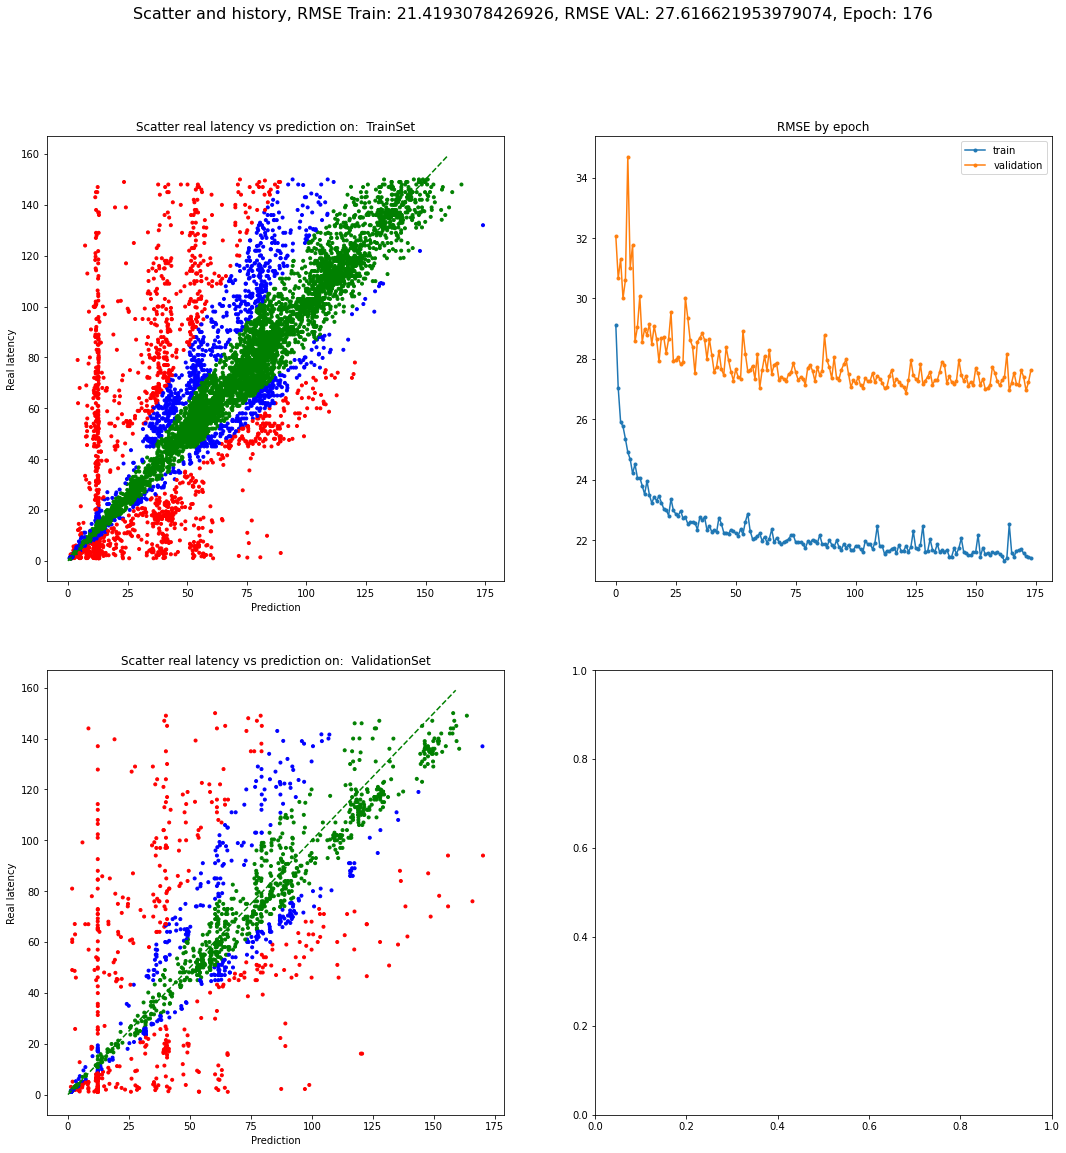

In [16]:
#Fit model
reg.fit(x_train_tree, x_train_query.values, y_train, x_val_tree, x_val_query.values, y_val)

#### SAVE MODEL

In [17]:
#Save best model
import torch
#torch.save(reg.best_model.state_dict(), "./best_model_fullADAM-7.0_V5.pt")
torch.save(reg.best_model.state_dict(), model_name + ".pt")
#Save stats in val set
file_to_store = open("./execution_model_stats_" + model_name + ".pickle", "wb")
pickle.dump(getpredictions_info_nojc(x_val_tree, x_val_query, y_val), file_to_store)
file_to_store.close()


In [18]:
pred_info = {"maxcardinality": maxcardinality, "tree_transform": reg.tree_transform}
pred_info

{'maxcardinality': 0,
 'tree_transform': <featurize.SPARQLTreeFeaturizer at 0x7fee17e40190>}

In [19]:
file_to_store = open("./preprocess_inference_info_" + model_name + ".pickle", "wb")
pickle.dump(pred_info, file_to_store)

In [20]:
dump(reg.pipeline, open('./pipeline_inverse_' + model_name + '.pkl', 'wb'))

#### TESTING

In [21]:
train_stats = getpredictions_info_nojc(x_train_tree, x_train_query, y_train)

In [22]:
train_stats

{'pred': (array([1.3692567], dtype=float32),
  array([1.129066], dtype=float32),
  array([20.698633], dtype=float32),
  array([1.0856688], dtype=float32),
  array([1.2803123], dtype=float32),
  array([1.1742675], dtype=float32),
  array([2.8534675], dtype=float32),
  array([52.22913], dtype=float32),
  array([11.541644], dtype=float32),
  array([2.3334332], dtype=float32),
  array([9.595206], dtype=float32),
  array([1.0272548], dtype=float32),
  array([76.84222], dtype=float32),
  array([1.1062775], dtype=float32),
  array([2.5918968], dtype=float32),
  array([1.0872667], dtype=float32),
  array([7.24632], dtype=float32),
  array([1.004904], dtype=float32),
  array([1.0872667], dtype=float32),
  array([1.5294647], dtype=float32),
  array([1.0872667], dtype=float32),
  array([1.6832387], dtype=float32),
  array([12.691749], dtype=float32),
  array([12.691749], dtype=float32),
  array([1.2004311], dtype=float32),
  array([1.1669188], dtype=float32),
  array([12.691749], dtype=float32),


In [23]:
#val_stats = getpredictions_info(x_val_tree, x_val_query, y_val)
val_stats = getpredictions_info_nojc(x_val_tree, x_val_query, y_val)

In [24]:
val_stats

{'pred': (array([12.691749], dtype=float32),
  array([1.0872667], dtype=float32),
  array([12.691749], dtype=float32),
  array([12.691749], dtype=float32),
  array([8.493123], dtype=float32),
  array([27.370897], dtype=float32),
  array([38.653797], dtype=float32),
  array([11.140321], dtype=float32),
  array([12.691749], dtype=float32),
  array([22.750322], dtype=float32),
  array([1.0575669], dtype=float32),
  array([8.205617], dtype=float32),
  array([12.691749], dtype=float32),
  array([1.218394], dtype=float32),
  array([48.28556], dtype=float32),
  array([1.0872667], dtype=float32),
  array([1.0575669], dtype=float32),
  array([12.691749], dtype=float32),
  array([1.473562], dtype=float32),
  array([12.691749], dtype=float32),
  array([1.218394], dtype=float32),
  array([63.61515], dtype=float32),
  array([12.691749], dtype=float32),
  array([4.6081557], dtype=float32),
  array([1.1490912], dtype=float32),
  array([1.0575669], dtype=float32),
  array([1.4722099], dtype=float32),


In [25]:
ds_val['y_pred'] = val_stats['pred']
ds_val['y_realcheck'] = val_stats['real']

In [26]:
test_stats = getpredictions_info_nojc(x_test_tree, x_test_query, y_test)

In [27]:
test_stats.keys()

dict_keys(['pred', 'real', 'mse', 'mae', 'rmse', 'history'])

In [28]:
ds_test['y_realcheck'] = test_stats['real']
ds_test['y_pred'] = test_stats['pred']

In [29]:
print(ds_test[['y_realcheck','y_pred']])

                                  y_realcheck        y_pred
0       [tensor(1.6879, dtype=torch.float64)]   [10.783762]
1       [tensor(1.6783, dtype=torch.float64)]   [4.6081557]
2       [tensor(1.1100, dtype=torch.float64)]   [12.691749]
3       [tensor(1.8582, dtype=torch.float64)]   [12.691749]
4       [tensor(1.5984, dtype=torch.float64)]   [16.260511]
...                                       ...           ...
1067      [tensor(107., dtype=torch.float64)]    [70.25187]
1068      [tensor(101., dtype=torch.float64)]    [98.87749]
1069      [tensor(123., dtype=torch.float64)]    [83.46329]
1070      [tensor(120., dtype=torch.float64)]  [115.771675]
1071  [tensor(138.0037, dtype=torch.float64)]    [82.47078]

[1072 rows x 2 columns]


In [30]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [31]:
def tag_points2(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_realcheck'][0]
    abs_diff = np.abs(difference)
    x['y_realcheck'] = x['y_realcheck'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [32]:
#tag_points(ds_test.values[0])
other = ds_test.apply(lambda x: tag_points(x), axis=1)

In [33]:
other.to_pickle("./predictions_test_" + model_name + ".pickle")

In [34]:
otherval = ds_val.apply(lambda x: tag_points(x), axis=1)

In [35]:
otherval.to_pickle("./predictions_val_" + model_name +".pickle")

In [36]:

fig = px.scatter(otherval[['query','query2','time','y_pred','color']], x="y_pred", y="time", color="color", hover_data=['query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Val Set")
fig.show()


In [37]:

fig = px.scatter(other[['query','query2','time','y_pred','y_realcheck','color']], x="y_pred", y="time", color="color", hover_data=['query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Test Set")
fig.show()


In [38]:
1+1

2

In [39]:
tot_val,b_val,a_val,g_val,bp_val,ap_val,gp_val = MetricTotalAccuraccy(otherval)
print(f"Total predictions: {tot_val}")
print(f"Bad predictions: {b_val}, percentage {bp_val}%")
print(f"Acceptable predictions: {a_val}, percentage {ap_val}%")
print(f"Good predictions: {g_val}, percentage {gp_val}%")

print(f"Accuraccy: {100*(a_val+g_val)/tot_val}%")

Total predictions: 1641
Bad predictions: 477, percentage 29.06764168190128%
Acceptable predictions: 315, percentage 19.195612431444243%
Good predictions: 849, percentage 51.736745886654475%
Accuraccy: 70.93235831809872%


In [40]:
tot_val,b_val,a_val,g_val,bp_val,ap_val,gp_val = MetricTotalAccuraccy(other)
print(f"Total predictions: {tot_val}")
print(f"Bad predictions: {b_val}, percentage {bp_val}%")
print(f"Acceptable predictions: {a_val}, percentage {ap_val}%")
print(f"Good predictions: {g_val}, percentage {gp_val}%")

print(f"Accuraccy: {100*(a_val+g_val)/tot_val}%")

Total predictions: 1072
Bad predictions: 306, percentage 28.544776119402986%
Acceptable predictions: 209, percentage 19.496268656716417%
Good predictions: 557, percentage 51.9589552238806%
Accuraccy: 71.45522388059702%


In [41]:
other

Unnamed: 0  index                                          unique_id  \
0              0   6766  75cde34cae5eb3909a60e519239740b1c2ac86fb5741aa...   
1              1   2538  333214b6c2b513a93dcd5e542d2bb25dc34f020bee19b8...   
2              2   6306  07a4e0a745b512b5b37ca2c44726ecbd01ffb049b36308...   
3              3   8552  35051b691d01b4c214bb376c818dd81dfe1fbe226841d0...   
4              4   2004  c409d94489ac28bcfb5c1487bc0d9284c9be1b1d9fb375...   
...          ...    ...                                                ...   
1067        1067   7321  1d624a62d8bfa1d0564bd67caaf5ce12e3e6d580913033...   
1068        1068  10339  fb60d53ed8686e681e10a5fc1bfbefff4f2a0ce85e4478...   
1069        1069   7133  aee0f9b6b512e02947168bac71a1184a482b86afd71c6c...   
1070        1070   7232  017f84fcdacbadad6c1b15358a9473bbacee7c808de4df...   
1071        1071   8201  80d90d98da77874c5b8c677130a98f494b766072a2c329...   

         filename                                              query  \
0      query_1621  SELECT DISTINCT * WHERE { ?v3 <http://www.wiki...   
1       query_887  SELECT  * WHERE   { ?var1  <http://www.wikidat...   
2     query_26341  SELECT  ?var1 (COUNT(DISTINCT ?var2) AS ?var3)...   
3     query_26378  SELECT DISTINCT ?var1 ?var1Label ?var2 WHERE {...   
4     query_19841  SELECT DISTINCT  ?p2 WHERE   { ?y  <http://www...   
...           ...                                                ...   
1067  query_27555  SELECT DISTINCT * WHERE { ?x (<http://www.wiki...   
1068  query_28892  SELECT DISTINCT  ?p1 WHERE   { ?y  <http://www...   
1069   query_1883  SELECT DISTINCT * WHERE { ?v0 <http://www.wiki...   
1070  query_26585  SELECT DISTINCT  ?p1 WHERE   { ?y  <http://www...   
1071   query_8314  SELECT * WHERE { ?y <http://www.wikidata.org/p...   

                                                  trees  \
0                ["VAR_URI_VARᶲIRI_ID;...direct/P481;"]   
1                ["VAR_URI_VARᶲIRI_ID;...direct/P281;"]   
2                ["VAR_URI_URIᶲIRI_ID;...direct/P279;"]   
3                ["VAR_URI_URIᶲIRI_ID;...direct/P279;"]   
4               ["VAR_URI_VARᶲIRI_ID;...direct/P7712;"]   
...                                                 ...   
1067  ["JOINᶲIRI_ID;...direct/P31;ᶲIRI_ID;...direct/...   
1068  ["JOINᶲIRI_ID;...direct/P1093;", ["VAR_URI_VAR...   
1069  ["JOINᶲIRI_ID;...direct/P180;ᶲIRI_ID;...direct...   
1070  ["JOINᶲIRI_ID;...direct/P5044;", ["VAR_URI_VAR...   
1071  ["JOINᶲIRI_ID;...direct/P1449;ᶲIRI_ID;...direc...   

                                                   bgps        time  \
0     {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...    1.687920   
1     {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...    1.678266   
2     {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...    1.109980   
3     {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...    1.858232   
4     {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...    1.598426   
...                                                 ...         ...   
1067  {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...  107.000000   
1068  {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...  101.000000   
1069  {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...  123.000000   
1070  {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...  120.000000   
1071  {'bgp_1': {'bgp_list': [{'S': 'None', 'P': 'IR...  138.003726   

      total_bgps  triples  treesize  join  left_join  iter  \
0              1        1         1     0          0     0   
1              1        1         1     0          0     0   
2              1        1         1     0          0     0   
3              1        1         1     0          0     0   
4              1        1         1     0          0     0   
...          ...      ...       ...   ...        ...   ...   
1067           1        2         2     1          0     0   
1068           1        2         2     1          0     0   
1069           1        2         2     1          0     0   
1070           1      

In [42]:
def transform_full(ds):
    val_p = []
    for i in ds["pred"]:
        val_p.append(float(i[0]))
    ds["pred"] = val_p
    val_r = []
    for i in ds["real"]:
        val_r.append(i.item())
    ds["real"] = val_r
    return ds

train_stats = getpredictions_info_nojc(x_train_tree, x_train_query, y_train)
test_stats = getpredictions_info_nojc(x_test_tree, x_test_query, y_test)
val_stats = getpredictions_info_nojc(x_val_tree, x_val_query, y_val)

train_stats = transform_full(train_stats)
test_stats = transform_full(test_stats)
val_stats = transform_full(val_stats)

with open('train_stats_'+model_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(train_stats, f)
with open('val_stats_'+model_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(val_stats, f)
with open('test_stats_'+model_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(test_stats, f)

In [43]:
f = open('train_stats_'+model_name+'.json')
x = f.read()

In [44]:
a = ast.literal_eval(x)
a

{'pred': [1.3692567348480225,
  1.129065990447998,
  20.698633193969727,
  1.0856688022613525,
  1.2803122997283936,
  1.1742675304412842,
  2.8534674644470215,
  52.229129791259766,
  11.541644096374512,
  2.333433151245117,
  9.595206260681152,
  1.0272548198699951,
  76.84221649169922,
  1.1062774658203125,
  2.5918967723846436,
  1.0872666835784912,
  7.246319770812988,
  1.00490403175354,
  1.0872666835784912,
  1.5294647216796875,
  1.0872666835784912,
  1.6832387447357178,
  12.69174861907959,
  12.69174861907959,
  1.2004311084747314,
  1.1669187545776367,
  12.69174861907959,
  12.69174861907959,
  12.69174861907959,
  12.69174861907959,
  6.5609235763549805,
  12.69174861907959,
  1.4556379318237305,
  1.0872666835784912,
  38.6537971496582,
  12.69174861907959,
  1.0872666835784912,
  12.69174861907959,
  1.1549959182739258,
  1.0872666835784912,
  12.69174861907959,
  1.0872666835784912,
  1.1341972351074219,
  1.024031162261963,
  1.6832387447357178,
  1.0297510623931885,


In [ ]:
xd